<a href="https://colab.research.google.com/github/rodriguezhh/IA_SIDIEN/blob/main/Inteligencia_Artificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DIAGNÓSTICO DE ENFERMEDADES EN LA HOJA DEL TOMATE MEDIANTE UN SISTEMA EMBEBIDO USANDO INTELIGENCIA ARTIFICIAL E IMÁGENES.
## Trabajo De Grado

## **Acceder al drive**

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Importación de librerías**

In [2]:
#librerias para el modelo
import tensorflow as tf
import keras
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np 

# librerias para el dataset
from keras.preprocessing.image import ImageDataGenerator

#librerias para las métricas 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **Base De Datos**
La base de datos consta de tres enfermedades de la hoja de la planta del tomate y la hoja sana de la misma. La información, en este caso las imágenes, tiene una dimensión de 256 x 256 píxeles.

Guardamos la información previamente separada en la variables train, validation y test.

In [3]:
# Definimos el tamaño de las imágenes y el tamaño del lote
image_size = 256 
batch_size = 32

# Creamos un generador de datos de imágenes para el entrenamiento con el objeto ImageDataGenerator
train_generator = ImageDataGenerator()

# Cargamos las imágenes de entrenamiento desde el directorio especificado y las transformamos utilizando el generador de datos
train = train_generator.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/TESIS/Dataset/60_20/train', # Ruta al directorio de entrenamiento
    target_size = (image_size, image_size), # Definimos el tamaño al que se redimensionarán todas las imágenes
    batch_size = batch_size, # Definimos el tamaño del lote
    shuffle = True, # Definimos si se barajarán aleatoriamente las imágenes en cada lote
    class_mode = 'categorical' # Definimos el modo de clasificación categórica
)

# Cargamos las imágenes de validación desde el directorio especificado y las transformamos utilizando el generador de datos
validation = train_generator.flow_from_directory( 
    '/content/drive/MyDrive/Colab Notebooks/TESIS/Dataset/60_20/val', # Ruta al directorio de validación
    target_size = (image_size, image_size), # Definimos el tamaño al que se redimensionarán todas las imágenes
    shuffle = False, # Definimos si se barajarán aleatoriamente las imágenes en cada lote
    batch_size = batch_size, # Definimos el tamaño del lote
    class_mode = 'categorical' # Definimos el modo de clasificación categórica
)

# Creamos otro generador de datos de imágenes para las imágenes de prueba
test_generator = ImageDataGenerator()

# Cargamos las imágenes de prueba desde el directorio especificado y las transformamos utilizando el generador de datos
test = test_generator.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/TESIS/Dataset/60_20/test', # Ruta al directorio de prueba
    target_size = (image_size, image_size), # Definimos el tamaño al que se redimensionarán todas las imágenes
    shuffle = False, # Definimos si se barajarán aleatoriamente las imágenes en cada lote
    batch_size = batch_size, # Definimos el tamaño del lote
    class_mode='categorical' # Definimos el modo de clasificación categórica
)


Found 7398 images belonging to 4 classes.
Found 1224 images belonging to 4 classes.
Found 1232 images belonging to 4 classes.


Las etiquetas de las imagenes son las siguietes:

In [4]:
train.class_indices

{'Tomato_Early_blight': 0,
 'Tomato_Late_blight': 1,
 'Tomato_healthy': 2,
 'Tomato_mosaic_virus': 3}

## **Modelo**

Model: "modelo_tomate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 127, 127, 32)     128       
 hNormalization)                                                 
                                                     

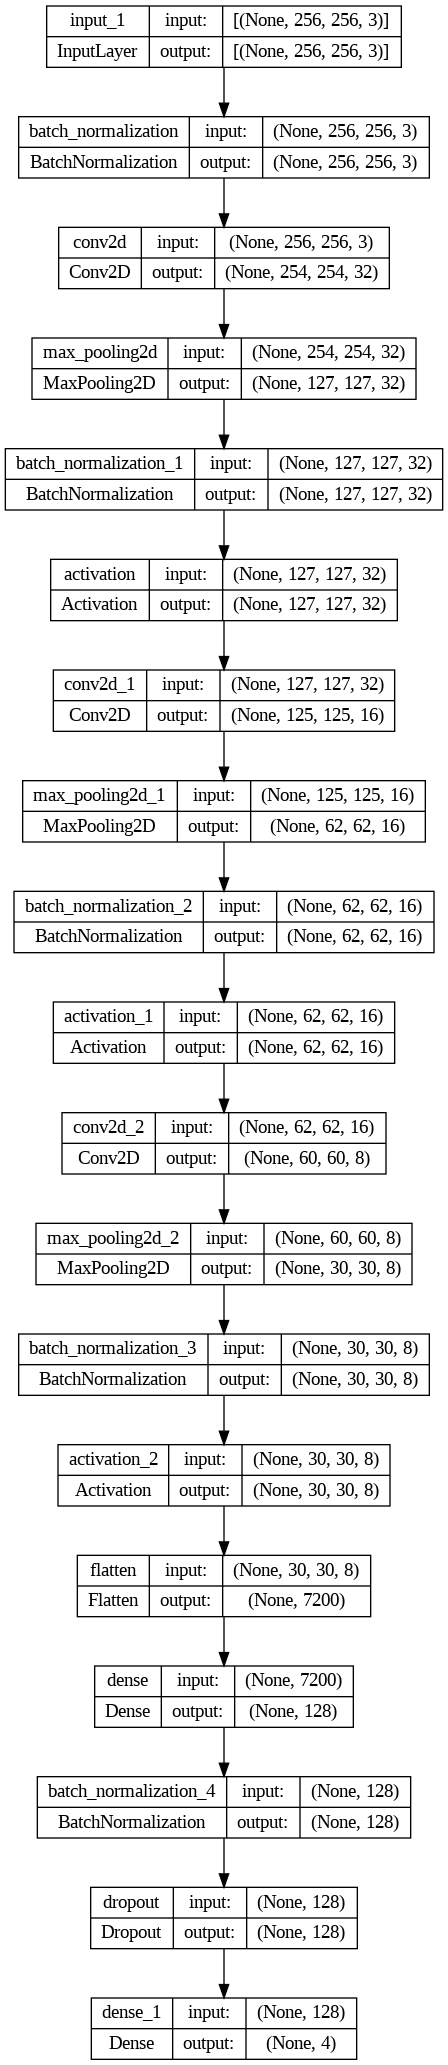

In [5]:
# Definir la cantidad de canales de la imagen
rgb = 3

# Definir la estructura de entrada del modelo
input_shape = (image_size, image_size, rgb)
inputs = keras.Input(shape= (input_shape))

# Capa de normalización de la entrada
x = layers.BatchNormalization()(inputs)

# Capas convolucionales
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding="valid", kernel_initializer='he_uniform')(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=None, padding="valid")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(filters=16, kernel_size=(3,3), padding="valid", kernel_initializer='he_uniform')(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=None, padding="valid")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(filters=8, kernel_size=(3,3), padding="valid", kernel_initializer='he_uniform')(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=None, padding="valid")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# Capa de aplanamiento
x = layers.Flatten()(x)

# Capa densa
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.BatchNormalization()(x)

# Capa de Dropout con 20% de probabilidad 
x = layers.Dropout(0.2)(x)

# Capa de salida con activación softmax
outputs = layers.Dense(4, activation="softmax", kernel_initializer='glorot_uniform')(x)

# Crear el modelo
model = keras.Model(inputs=inputs, outputs=outputs, name="modelo_tomate")

# Resumen del modelo
model.summary()

# Grafica la estructura del modelo
keras.utils.plot_model(model, "modelo_tomate.png", show_shapes=True)

## **Método Compile de Keras**
Definiendo el optimizador, la función de perdida y la métrica.

1.   Optimizadior: Adam. 
2.   Función de perdida: categorical_crossentropy. Porque previamente se definieron las etiquetas como "one-hot".
3.   Métrica: Accuracy. Se escoge la exactitud porque es la varible estandar de interes de un modelo. 



In [6]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),
 loss= keras.losses.CategoricalCrossentropy(),
 metrics=["accuracy"])

## **Callbacks**


1.   EarlyStopping: Nos permite detener el entrenamiento cuando la variable que se monitorea deja de mejorar. 
2.   ReduceLROnPlateau: Reduce el "learning rate" cuando la variable que se monitorea deja de mejorar. 






In [7]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # La métrica que se va a monitorear para detener el entrenamiento
    patience=5,                    # El número de épocas que esperará antes de detener el entrenamiento
    verbose=1,                     # El nivel de detalle que se mostrará durante el entrenamiento
    restore_best_weights=True      # Si se deben restaurar los pesos del modelo a la mejor época durante el entrenamiento
)

In [8]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',           # La métrica que se va a monitorear para reducir la tasa de aprendizaje
    factor=0.2,                   # Factor de reducción de la tasa de aprendizaje
    patience=2,                   # El número de épocas que esperará antes de reducir la tasa de aprendizaje
    verbose=1                     # El nivel de detalle que se mostrará durante el entrenamiento
)

## **Entrenamiento del modelo**

In [9]:
history = model.fit(
    train,
    batch_size = batch_size,
    validation_data = validation, 
    epochs = 9000000,
    callbacks = [earlystopping, reduce_lr],
    )

Epoch 1/9000000
232/232 [==============================] - 961s 4s/step - loss: 0.5794 - accuracy: 0.7771 - val_loss: 0.6331 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 2/9000000
232/232 [==============================] - 37s 159ms/step - loss: 0.3267 - accuracy: 0.8800 - val_loss: 0.4529 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 3/9000000
232/232 [==============================] - 36s 156ms/step - loss: 0.2641 - accuracy: 0.8994 - val_loss: 0.3522 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 4/9000000
232/232 [==============================] - 35s 152ms/step - loss: 0.2369 - accuracy: 0.9125 - val_loss: 0.7567 - val_accuracy: 0.7958 - lr: 0.0010
Epoch 5/9000000
232/232 [==============================] - 36s 153ms/step - loss: 0.1907 - accuracy: 0.9334 - val_loss: 0.2921 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 6/9000000
232/232 [==============================] - 37s 160ms/step - loss: 0.1654 - accuracy: 0.9397 - val_loss: 0.5187 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 7/9000000
232/232 

## **Evaluando el modelo**

In [10]:
scores = model.evaluate(test)
print(scores)

39/39 [==============================] - 186s 5s/step - loss: 0.2988 - accuracy: 0.8953
[0.2987934947013855, 0.8952922224998474]


## **Gráficas de 'Accuracy' y 'Loss' del modelo**

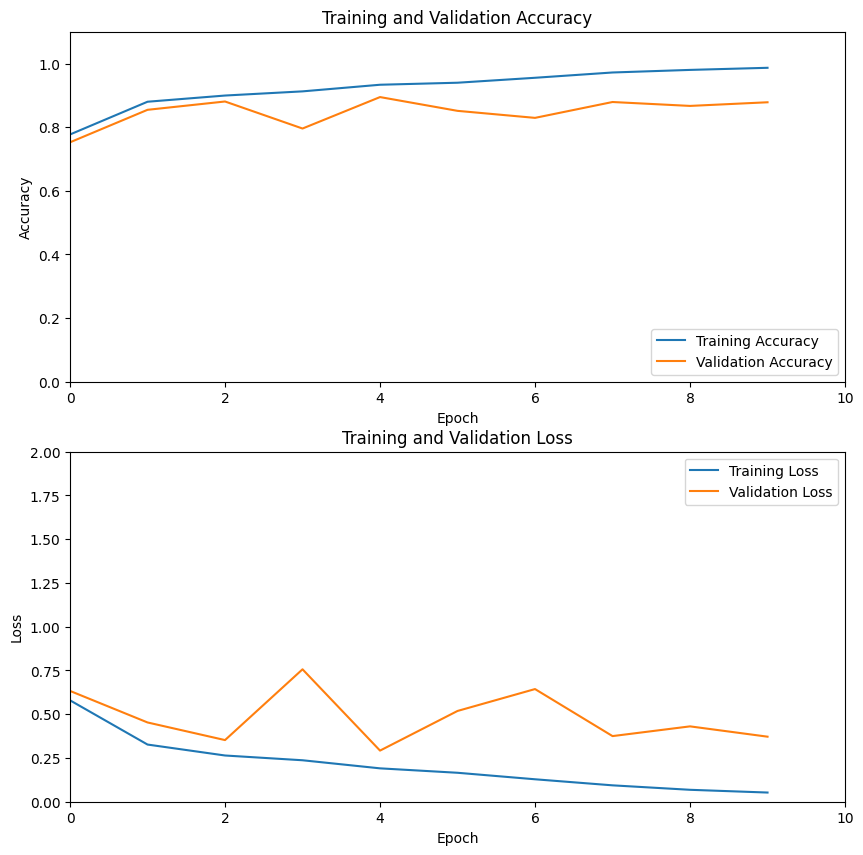

In [17]:
# Se crea una figura con dos imagenes
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

# Se grafica la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Se añaden nombres a los ejes y se agrega una leyenda y un título a la imagen
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlim([0, 10])  # Establecer los límites del eje x
plt.ylim([0, 1.1])  # Establecer los límites del eje y

# Se crea la segunda imagen
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Se añaden nombres a los ejes y se agrega una leyenda y un título a la imagen
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlim([0, 10])  # Establecer los límites del eje x
plt.ylim([0, 2])  # Establecer los límites del eje y


# Se muestran los gráficos
plt.show()

## **Matriz de confusión**

39/39 [==============================] - 5s 118ms/step


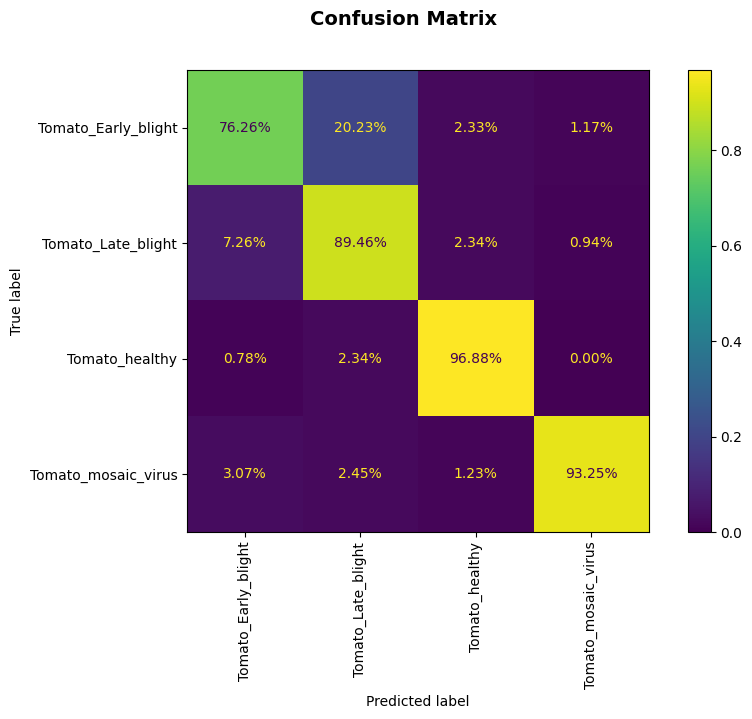

In [12]:
# Generar predicciones en el conjunto de prueba
predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las clases verdaderas y las etiquetas de las clases
true_classes = test.classes
class_labels = list(test.class_indices.keys())    

# Calcular la matriz de confusión normalizada
cm = confusion_matrix(
    y_true=true_classes,
    y_pred=predicted_classes,
    normalize='true')

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical", values_format=".2%")

# Configurar el título del gráfico
fig.suptitle("Confusion Matrix", fontsize=14, fontweight='bold')

# Mostrar el gráfico
plt.show()

## **Métricas**

In [13]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

                     precision    recall  f1-score   support

Tomato_Early_blight       0.83      0.76      0.80       257
 Tomato_Late_blight       0.85      0.89      0.87       427
     Tomato_healthy       0.95      0.97      0.96       385
Tomato_mosaic_virus       0.96      0.93      0.94       163

           accuracy                           0.90      1232
          macro avg       0.90      0.89      0.89      1232
       weighted avg       0.89      0.90      0.89      1232



## **Guardando el modelo**

In [14]:
model.save('TOLD2.h5')